# 3: Assessing model performance and applicability

Author: Daniel Lusk

## Imports

In [6]:
import pandas as pd
import dask_geopandas as dgpd
from utils.models import TrainedSet, Prediction
from pathlib import Path

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Model performance

Get the training run data from the results dataframe and choose a model

Load unseen predictor data and run prediction

In [3]:
results = pd.read_csv("./results/training_results.csv").copy()

In [4]:
# Key trait ids
prim_trait_idx = [26, 11, 4, 18]  # 26 = Seed dry mass, 11 = SLA, 4 = SSD, 18 = Height

In [5]:
# First filter results to only include rows that were not imputed
results = results.loc[results["NaN strategy"] == "all"]

# Filter results to only include rows in which Response variable starts with GBIF
gbif_res = results.loc[results["Response variable"].str.startswith("GBIF")]
splot_res = results.loc[results["Response variable"].str.startswith("sPlot")]

# Filter results to only include rows in which Response variable does not contain "_ln"
gbif_res = gbif_res.loc[~gbif_res["Response variable"].str.contains("_ln")]
splot_res = splot_res.loc[~splot_res["Response variable"].str.contains("_ln")]

# For each trait in prim_trait_idx, get the row corresponding to its highest CV r-squared
# Do this by finding the rows in which "Response variable" contains the trait id (e.g. "_X{trait_id}_}")
# Then sort by "CV r-squared" and keep the first row
gbif_best = []
splot_best = []

for trait_id in prim_trait_idx:
    gbif_best.append(
        gbif_res.loc[gbif_res["Response variable"].str.contains(f"_X{trait_id}_")].sort_values(
            by="CV r-squared", ascending=False
        ).iloc[0]
    )
    splot_best.append(
        splot_res.loc[splot_res["Response variable"].str.contains(f"_X{trait_id}_")].sort_values(
            by="CV r-squared", ascending=False
        ).iloc[0]
    )

In [6]:
for row in gbif_best[:1]:
    trained = TrainedSet.from_results_row(row)

    tiles = Path(
        "data/collections/tiled_5x5_deg_MOD09GA.061_ISRIC_soil_WC_BIO_VODCA_0.01_deg/"
    ).glob("*.parq*")

    tiled_pred_dir = Path(
        f"./results/predictions/MOD09GA.061_ISRIC_soil_WC_BIO_VODCA_0.01_deg/{trained.y_name}/tiled_5x5_deg/"
    )
    tiled_pred_dir.mkdir(exist_ok=True, parents=True)

    for tile in tiles:
        new_df = dgpd.read_parquet(tile).compute()
        new_df_imp = dgpd.read_parquet(f"{tile.parent}_imputed/{tile.name}").compute()
        tile_pred = Prediction(trained, new_df, new_df_imp)
        tile_pred_df = tile_pred.df
        tile_pred_df.to_parquet(tiled_pred_dir / tile.name)

Dropping unnecessary columns...
Masking oceans...
Dropping unnecessary columns...
Masking oceans...
XY shape before dropping full-NA rows/cols: (85959, 164)
XY shape after:                             (33169, 164)
# of rows excluded: 52790 (61.41%)

No columns were dropped.


In [7]:
pred = Prediction(trained, new_df.compute())

In [ ]:
pred.df.plot(column=pred.df.columns[-2], markersize=0.5)

Calculating Area of Applicability...
Droppping Index(['C_2002-2004_multiyear_mean_m01'], dtype='object')...
Scaling data...
Applying feature weights...
Calculating nearest training instance...
Runtime took 417.04 seconds
Calculating pairwise distances...
Runtime took 42.45 seconds
Masking training points in same fold...
Calculating AOA...
Runtime took 3.66 seconds


<Axes: >

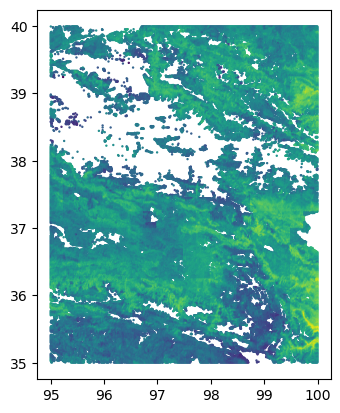

In [90]:
pred.df.plot(column=pred.df.columns[-2], markersize=0.5)

# Explore full results

In [19]:
# Rename response variable values according to the trait id -> trait name mapping
import json

with open("./trait_id_to_trait_name.json", "r") as f:
    mapping = json.load(f)

# Replace each observation in "Response variable" column according to the pattern "TRYgapfilled_X{trait_id}_" with {trait_name}
for trait_id, trait_name in mapping.items():
    results["Response variable"] = results["Response variable"].str.replace(
        f"TRYgapfilled_X{trait_id}_", f"{trait_name}_"
    )

results = results[["Run ID", "Response variable", "CV nRMSE", "CV nRMSE STD", "CV r-squared", "CV r-squared STD", "Test r-squared", "Predictor importance"]]

# Filter only response variables that start with "GBIF"
results = results[results["Response variable"].str.startswith("GBIF")]
results.sort_values(by="CV r-squared", ascending=False).head(60)

,Run ID,Response variable,CV nRMSE,CV nRMSE STD,CV r-squared,CV r-squared STD,Test r-squared,Predictor importance
142,2023-08-27_13-12-46,GBIF_Stem conduit density_05deg_mean_ln,0.210546,0.009650,0.525364,0.029834,0.728242,"[['wc2.1_0.5_deg_bio_1', 0.047118447721004486]..."
10,2023-08-26_20-17-00,GBIF_Stem conduit density_05deg_mean,0.242687,0.009430,0.492563,0.032633,0.747018,"[['bdod_0-5cm_mean_0.5_deg', 0.049330338835716..."
76,2023-08-26_21-36-46,GBIF_Stem conduit density_05deg_mean,0.244919,0.018713,0.484804,0.042445,0.742175,[['2000-2004_sur_refl_multiyear_mean_m4_band03...
148,2023-08-27_13-12-46,GBIF_Seed dry mass_05deg_mean_ln,0.227128,0.012485,0.447462,0.047489,0.691337,"[['wc2.1_0.5_deg_bio_1', 0.04050648212432861],..."
97,2023-08-26_21-36-46,GBIF_Leaf delta 15N_05deg_mean,0.235457,0.007722,0.446569,0.028137,0.687785,"[['nitrogen_0-5cm_mean', 0.03677196800708771],..."
31,2023-08-26_20-17-00,GBIF_Leaf delta 15N_05deg_mean,0.236843,0.014548,0.443139,0.038214,0.689407,"[['ocd_0-5cm_mean_0.5_deg', 0.0502967126667499..."
162,2023-08-27_13-12-46,GBIF_Root rooting depth_05deg_mean_ln,0.247706,0.013629,0.434573,0.026886,0.685342,[['2000-2004_sur_refl_multiyear_mean_m3_band04...
163,2023-08-27_13-12-46,GBIF_Leaf delta 15N_05deg_mean_ln,0.240544,0.008044,0.426186,0.041636,0.737376,"[['wc2.1_0.5_deg_bio_1', 0.03456808626651764],..."
153,2023-08-27_13-12-46,GBIF_Leaf area_05deg_mean_ln,0.238674,0.012221,0.385875,0.043738,0.628505,"[['X_2000-2004_multiyear_mean_m01', 0.03203320..."
149,2023-08-27_13-12-46,GBIF_Seed length_05deg_mean_ln,0.242090,0.015750,0.374911,0.029350,0.643112,[['2000-2004_sur_refl_multiyear_mean_m3_band03...
